In [ ]:
# !pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [3]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\mater\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [4]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [7]:
emotion_dataset["train"]["label"][0]

0

In [8]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [9]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [10]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [11]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [12]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [14]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [15]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [16]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output["attention_mask"],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [17]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [18]:
batch_size = 32 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [19]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8,
    resid_pdrop=0.3,
    embd_pdrop=0.3,
    attn_pdrop=0.3    
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [20]:
lr = 1e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.AdamW(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [21]:
x = train_dataset[0]

In [22]:
tokens = x["input_ids"] # Получи токены из датасета
mask = x["mask"] # Получи маску из датасета

model_0(input_ids=tokens.to(device), attention_mask=mask.to(device)).logits # Посмотри на аутпут

tensor([[-0.6604, -0.2947, -0.3201,  0.6121, -0.1545,  0.9514,  0.0906, -0.5189]],
       device='cuda:0', grad_fn=<IndexBackward>)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [28]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
best_val_acc = None
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        targets = batch["target"].to(device)
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["mask"].squeeze(1).to(device)
        logits = model_0(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == targets).sum().item()
        
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            targets = batch["target"].to(device)
            tokens = batch["input_ids"].squeeze(1).to(device)
            mask = batch["mask"].squeeze(1).to(device)
            logits = model_0(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(logits, targets)
            valid_loss += loss.item()
            valid_acc += (logits.argmax(dim=1) == targets).sum().item()
        if best_val_acc is None or best_val_acc > valid_acc:
            torch.save(model_0.state_dict(), "./best_model_0.pkl")
            
            
    print(f"Train Loss: {train_loss / len(train_loader)}, "
          f"Train acc: {train_acc / len(train_dataset)}, "
          f"Valid Loss: {valid_loss / len(valid_loader)}, "
          f"Valid Acc: {valid_acc / len(valid_dataset)}")

# Testing
model_0.load_state_dict(torch.load("./best_model_0.pkl"))
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch["target"].to(device)
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["mask"].squeeze(1).to(device)
        logits = model_0(input_ids=tokens, attention_mask=mask).logits
        test_acc += (logits.argmax(dim=1) == targets).sum().item()
print(f"Test Acc: {test_acc / len(test_dataset)}")

  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 1.31934287661314, Train acc: 0.494625, Valid Loss: 0.48517355748585295, Valid Acc: 0.844


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.37375231356918814, Train acc: 0.8704375, Valid Loss: 0.29264003990425, Valid Acc: 0.892


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.2029363659210503, Train acc: 0.92475, Valid Loss: 0.28026835762319113, Valid Acc: 0.8985


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.13967158937454224, Train acc: 0.9485, Valid Loss: 0.3119703984213254, Valid Acc: 0.898


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.10666743422020226, Train acc: 0.9595625, Valid Loss: 0.3072141939035011, Valid Acc: 0.898


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.08260648582037539, Train acc: 0.9696875, Valid Loss: 0.3178744891007978, Valid Acc: 0.9025


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.07342245708312839, Train acc: 0.9739375, Valid Loss: 0.34971174071469, Valid Acc: 0.9065


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.0590207466899883, Train acc: 0.979125, Valid Loss: 0.34042105109002146, Valid Acc: 0.904


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.05316687453514896, Train acc: 0.9805625, Valid Loss: 0.40714407806831693, Valid Acc: 0.9


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.04047446999652311, Train acc: 0.985, Valid Loss: 0.4120079085733446, Valid Acc: 0.8965
Test Acc: 0.885


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [24]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [25]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [26]:
text = emotion_dataset["validation"]["text"][0] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

C:\Users\mater\AppData\Local\Temp/ipykernel_20408/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\mater\AppData\Local\Temp/ipykernel_20408/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


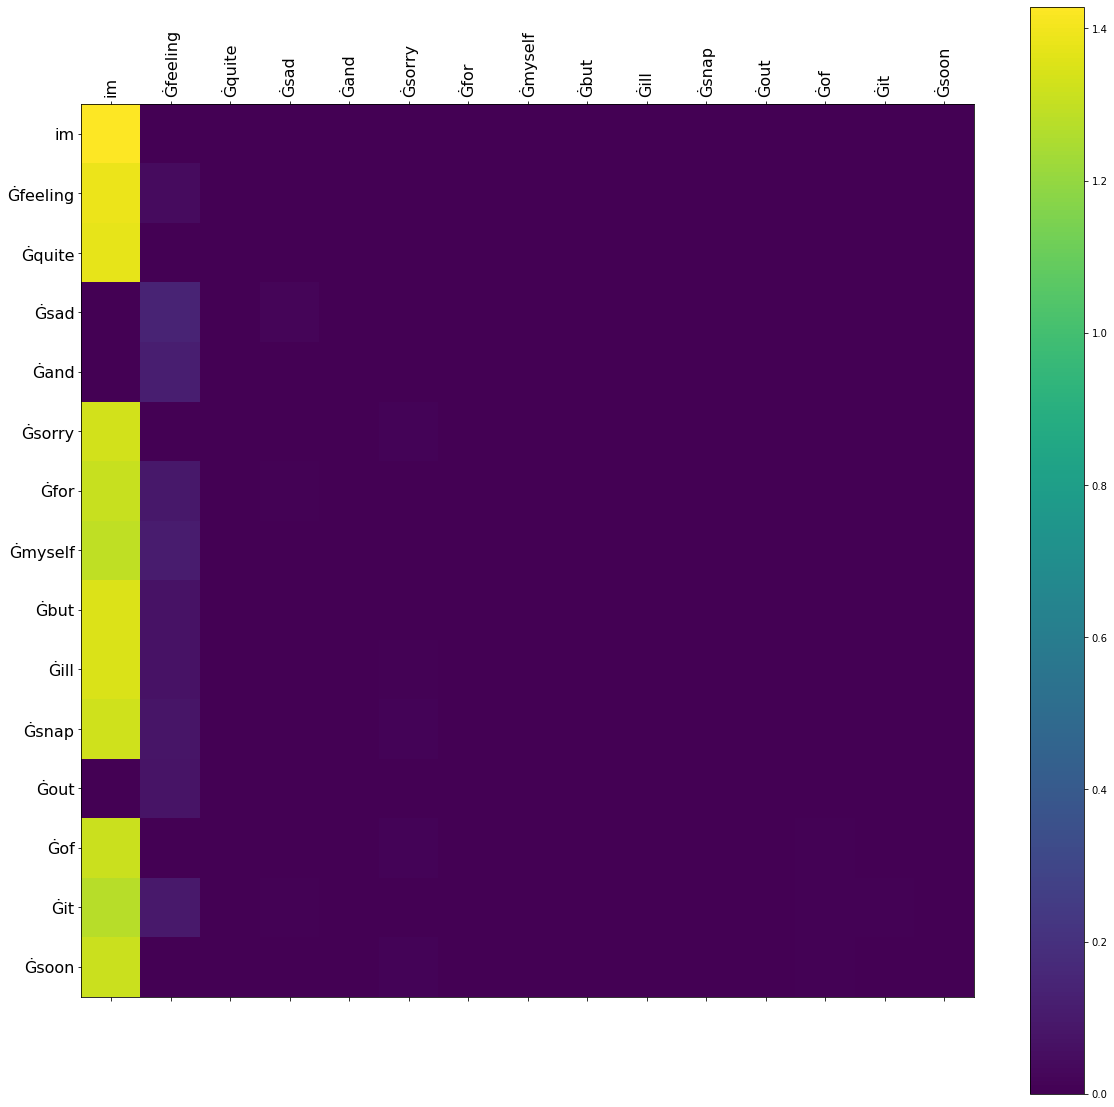

In [29]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [30]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8,
    resid_pdrop=0.3,
    embd_pdrop=0.3,
    attn_pdrop=0.3    
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
lr = 1e-4 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.AdamW(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [37]:
num_epochs = 10

# Train loop
best_val_acc = None
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        targets = batch["target"].to(device)
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["mask"].squeeze(1).to(device)
        logits = model_1(input_ids=tokens, attention_mask=mask).logits
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == targets).sum().item()
        
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            targets = batch["target"].to(device)
            tokens = batch["input_ids"].squeeze(1).to(device)
            mask = batch["mask"].squeeze(1).to(device)
            logits = model_1(input_ids=tokens, attention_mask=mask).logits
            loss = criterion(logits, targets)
            valid_loss += loss.item()
            valid_acc += (logits.argmax(dim=1) == targets).sum().item()
        if best_val_acc is None or best_val_acc > valid_acc:
            torch.save(model_1.state_dict(), "./best_model_1.pkl")
            
            
    print(f"Train Loss: {train_loss / len(train_loader)}, "
          f"Train acc: {train_acc / len(train_dataset)}, "
          f"Valid Loss: {valid_loss / len(valid_loader)}, "
          f"Valid Acc: {valid_acc / len(valid_dataset)}")

# Testing
model_1.load_state_dict(torch.load("./best_model_1.pkl"))
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        targets = batch["target"].to(device)
        tokens = batch["input_ids"].squeeze(1).to(device)
        mask = batch["mask"].squeeze(1).to(device)
        logits = model_1(input_ids=tokens, attention_mask=mask).logits
        test_acc += (logits.argmax(dim=1) == targets).sum().item()
print(f"Test Acc: {test_acc / len(test_dataset)}")

  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.8674851939231157, Train acc: 0.6840625, Valid Loss: 0.297851758462096, Valid Acc: 0.9065


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.24708769664540886, Train acc: 0.908, Valid Loss: 0.18869451065695594, Valid Acc: 0.9325


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.17724697997979819, Train acc: 0.9298125, Valid Loss: 0.1602524899848042, Valid Acc: 0.9325


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.14818597335834055, Train acc: 0.935875, Valid Loss: 0.14131652194515076, Valid Acc: 0.935


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.12644090919103473, Train acc: 0.9411875, Valid Loss: 0.14601986061519248, Valid Acc: 0.936


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.11976871806103737, Train acc: 0.9431875, Valid Loss: 0.13349309074322854, Valid Acc: 0.9405


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.10886158136045561, Train acc: 0.948375, Valid Loss: 0.12578739643435083, Valid Acc: 0.9385


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.09946399715542793, Train acc: 0.949625, Valid Loss: 0.11592645364044796, Valid Acc: 0.946


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.09304806842189282, Train acc: 0.9531875, Valid Loss: 0.12508138860807994, Valid Acc: 0.9435


  0%|          | 0/500 [00:00<?, ?it/s]

Train Loss: 0.09195295942365192, Train acc: 0.953625, Valid Loss: 0.14679443857918764, Valid Acc: 0.936
Test Acc: 0.931


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

C:\Users\mater\AppData\Local\Temp/ipykernel_20408/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\mater\AppData\Local\Temp/ipykernel_20408/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


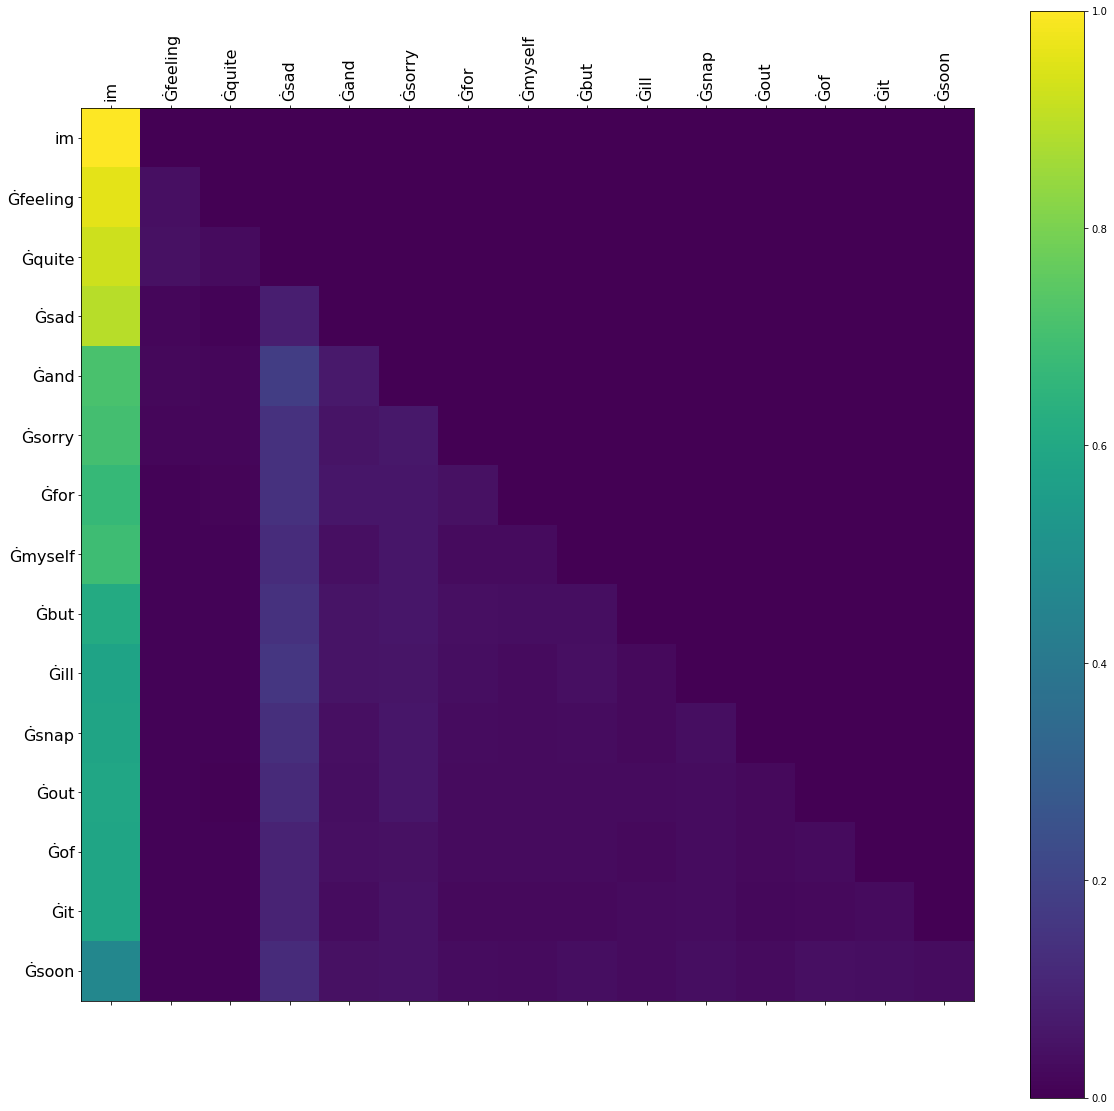

In [33]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

#### Какой подход оказался лучше?

Наилучшим образом показал себя подход с предобученной моделью. На тестовой выборке его точность достигла значения 0.931, модель с нуля достигла точности 0.885.

#### На какие слова модель большего всего обращала внимание?

Рассмотрим в качестве примера предложенный последний слой первой головы. Обе модели в основном обращают внимание на первое слово в предложении, хотя можно сказать, что предобученная модель на очередной итерации по немногу смотрит на все предыдущие слова предложения. Посмотрим на все слои/головы предобученной модели.

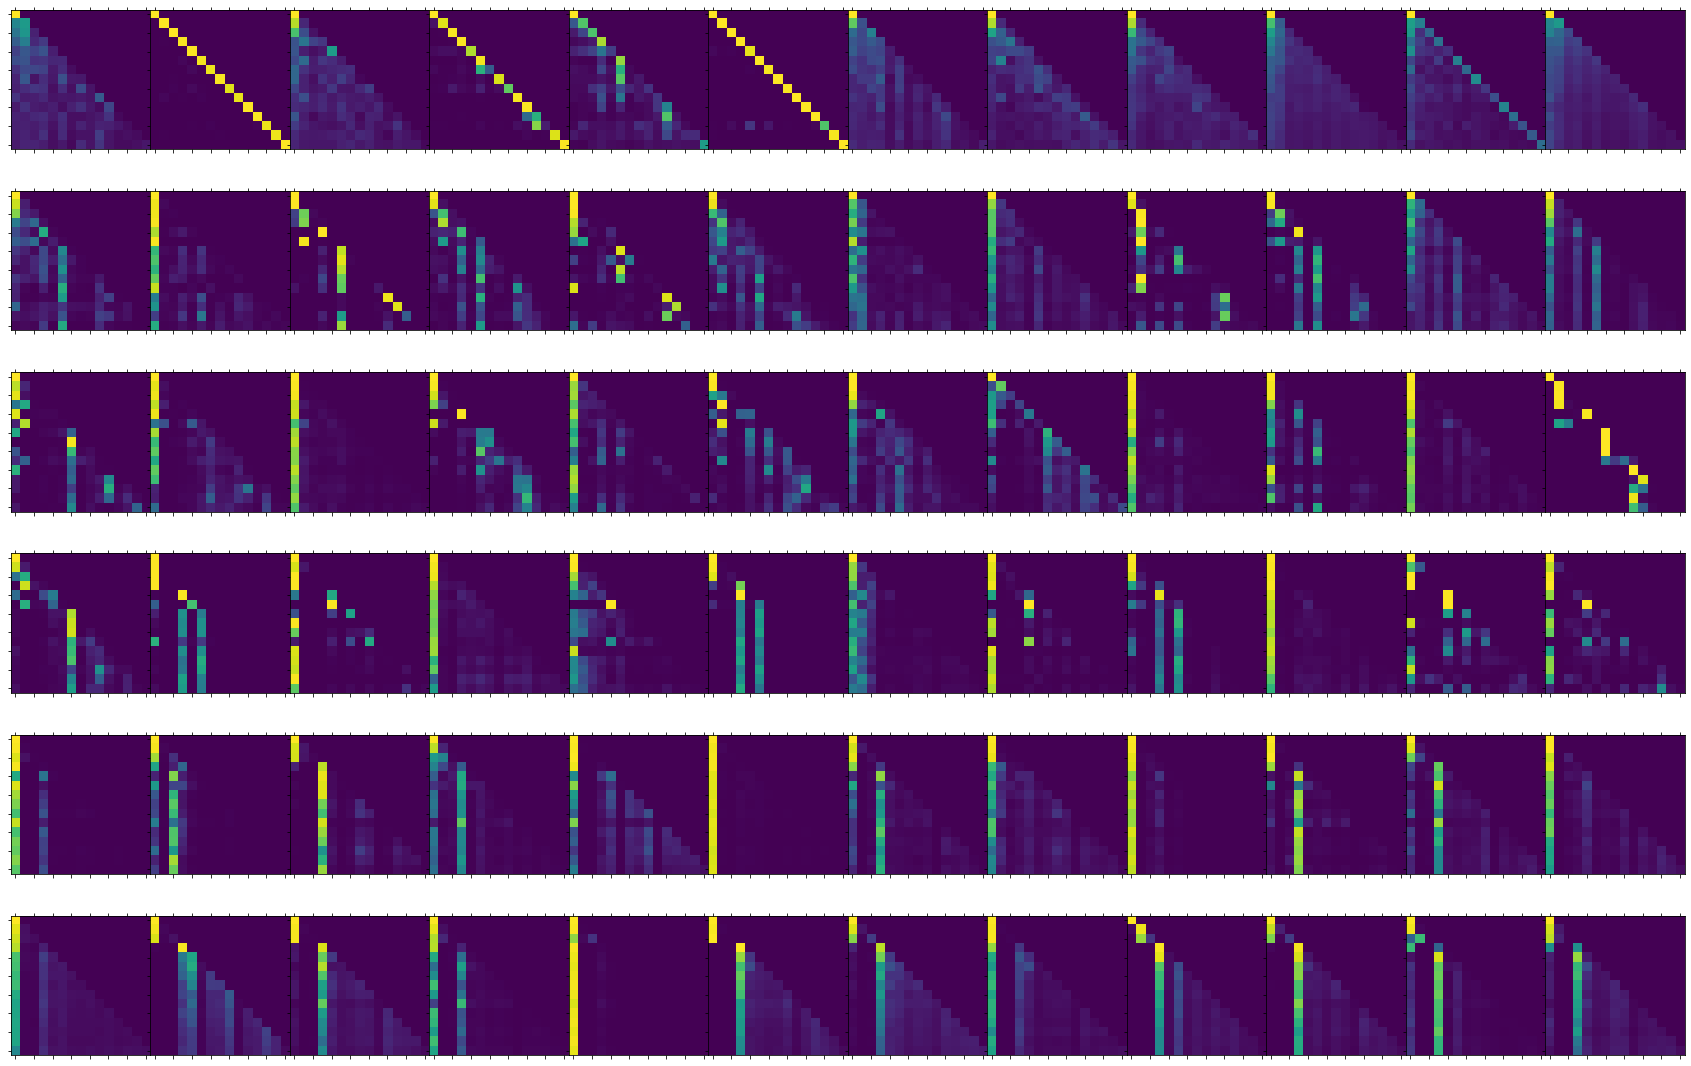

In [44]:
fig = plt.figure(figsize=(30,20))
n = 0
for i in range(attns.shape[0]):
    for j in range(attns.shape[1]):
        n += 1
        ax = fig.add_subplot(attns.shape[0], attns.shape[1], n)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.matshow(attns[i][j])
plt.subplots_adjust(wspace=0, hspace=0)

Можно видеть, что многие слои/головы действительно в основном смотрят на первое слово. Однако встречают и такие слои, которые смотрят лишь на очередное слово, либо +- равномерно смотрят на все предыдущие слова.

#### На каких слоях/головах модель обращала внимание?

In [45]:
from bertviz import model_view

In [46]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [47]:
model_view(torch.Tensor(attns).unsqueeze(1), tokens)

<IPython.core.display.Javascript object>

Видно, что слои/головы разделяются на несколько групп:
1. при очередной итерации модель смотрит лишь на текущее слово (например, 0 строка 1 столбец);
2. при очередной итерации модель в основном смотрит на первое слово (например, 2 строка 10 столбец);
3. при очередной итерации модель +- равномерно смотрит на все предыдущие слова (например, 1 строка 3 столбец).

Многие слои/головы в основном смотрят на первое слово предложения, меньшее количество слоев смотрят на все слова или на текущее слово.